<a href="https://colab.research.google.com/github/KaurSukhvinder/Leukemia-Detection-using-DL-/blob/main/Leukemia(BloodCancer)_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from PIL import Image
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_dir = '/content/drive/MyDrive/blood'
print(os.listdir(data_dir))

['Original', 'Segmented']


In [4]:
folders = ['Original', 'Segmented']  # Main folders to loop over
categories = ['Benign', 'Early', 'Pre', 'Pro']  # Subfolder categories

#1.Image Loading and Labeling

In [5]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import Sequence

In [6]:
# Initialize lists for images and labels
images, labels, sources = [], [], []

# Load images and labels
for folder in folders:
    for label, category in enumerate(categories):
        folder_path = os.path.join(data_dir, folder, category)  # Path to each category folder in Original and Segmented
        for filename in os.listdir(folder_path):
            img_path = os.path.join(folder_path, filename)
            try:
                # Load and resize image
                image = Image.open(img_path).convert('RGB').resize((224, 224))  # Resize to (224, 224)
                images.append(np.array(image))
                labels.append(label)  # Use numeric label for each category
                sources.append(folder)  # Keep track of whether the image came from Original or Segmented
            except Exception as e:
                print(f"Error loading {img_path}: {e}")

# Convert lists to numpy arrays and normalize images
images = np.array(images) / 255.0  # Scale pixel values to [0, 1]
labels = np.array(labels)

print("Loaded images:", images.shape)
print("Loaded labels:", labels.shape)
print("Source folders (Original/Segmented):", sources[:10])  # Print first 10 source folders as a check

Loaded images: (6522, 224, 224, 3)
Loaded labels: (6522,)
Source folders (Original/Segmented): ['Original', 'Original', 'Original', 'Original', 'Original', 'Original', 'Original', 'Original', 'Original', 'Original']


# 2. Data Preprocessing and Augmentation

In [7]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input  # Import the preprocess_input function
from tensorflow.keras.utils import Sequence
import numpy as np
import os
from PIL import Image

class ImageBatchGenerator(Sequence):
    def __init__(self, data_dir, categories, batch_size=16, img_size=(224, 224), augment=False, shuffle=True):
        self.data_dir = data_dir
        self.categories = categories
        self.batch_size = batch_size
        self.img_size = img_size  # Updated to (224, 224) for VGG16
        self.augment = augment
        self.shuffle = shuffle
        self.image_paths = []
        self.labels = []

        # Build the image paths and labels list
        for label, category in enumerate(categories):
            category_dir = os.path.join(data_dir, 'Original', category)
            for filename in os.listdir(category_dir):
                if filename.endswith(('.jpg', '.jpeg', '.png')):
                    self.image_paths.append(os.path.join(category_dir, filename))
                    self.labels.append(label)

        self.labels = np.array(self.labels)
        self.indexes = np.arange(len(self.image_paths))
        self.on_epoch_end()

        # Initialize the data augmenter if augmentation is enabled
        self.train_datagen = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        ) if self.augment else None

    def __len__(self):
        return int(np.floor(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_image_paths = [self.image_paths[k] for k in batch_indexes]
        batch_labels = self.labels[batch_indexes]

        # Load and preprocess images
        batch_images = np.array([self.load_and_preprocess_image(img_path) for img_path in batch_image_paths])

        # Apply data augmentation if needed
        if self.augment:
            batch_images = np.array([self.train_datagen.random_transform(img) for img in batch_images])

        return batch_images, batch_labels

    def load_and_preprocess_image(self, img_path):
        # Load an image, resize, and normalize
        image = Image.open(img_path).convert('RGB')
        image = image.resize(self.img_size)  # Resize to (224, 224) for VGG16
        image = np.array(image)
        image = preprocess_input(image)  # Preprocess the image for VGG16
        return image

    def on_epoch_end(self):
        # Shuffle data at the end of each epoch
        if self.shuffle:
            self.indexes = np.arange(len(self.image_paths))
            np.random.shuffle(self.indexes)

# Create the data generator for training and validation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,  # Normalize images
    validation_split=0.2,  # 20% of data for validation
    rotation_range=20,  # Data augmentation
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Training data generator
train_generator = train_datagen.flow_from_directory(
    directory=data_dir,
    target_size=(224, 224),  # Resize to (224, 224) for VGG16
    batch_size=8,  # Batch size for training
    class_mode='sparse',
    subset='training'  # Use the training split
)

# Validation data generator
validation_generator = train_datagen.flow_from_directory(
    directory=data_dir,
    target_size=(224, 224),  # Resize to (224, 224) for VGG16
    batch_size=8,  # Batch size for validation
    class_mode='sparse',
    subset='validation'  # Use the validation split
)

print("Data preprocessing and augmentation are set up!")


Found 5218 images belonging to 2 classes.
Found 1304 images belonging to 2 classes.
Data preprocessing and augmentation are set up!


# 3. EDA

## i) Image Count by Category

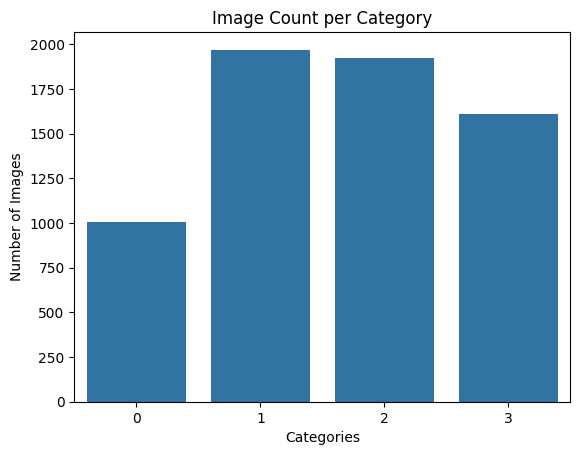

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Count the number of images per label
label_counts = Counter(labels)
sns.barplot(x=list(label_counts.keys()), y=list(label_counts.values()))
plt.xlabel("Categories")
plt.ylabel("Number of Images")
plt.title("Image Count per Category")
plt.show()

### ii) Sample Visualization: Display a few images per category to observe their visual diversity

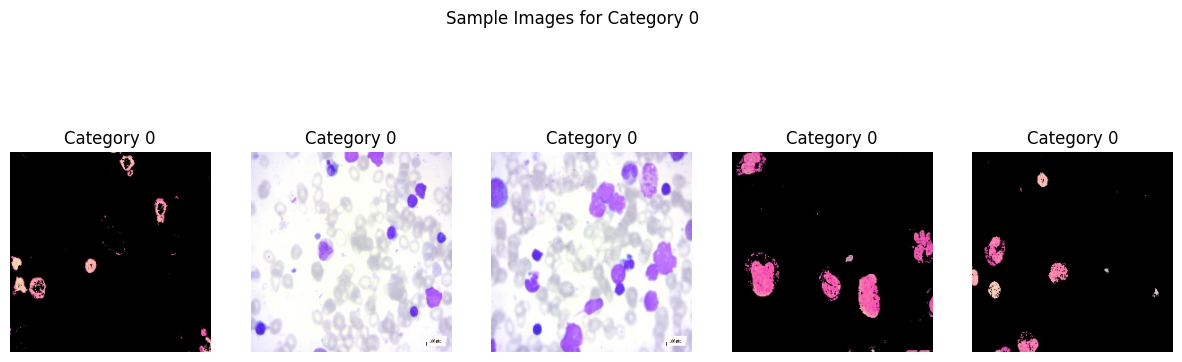

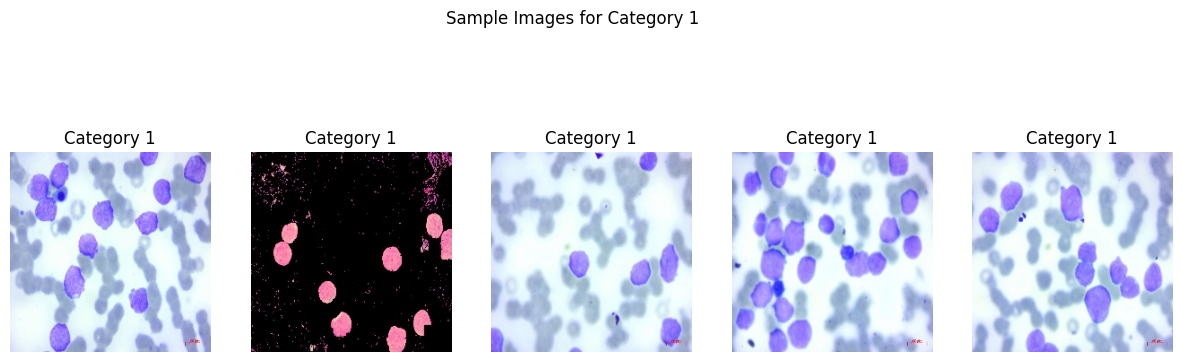

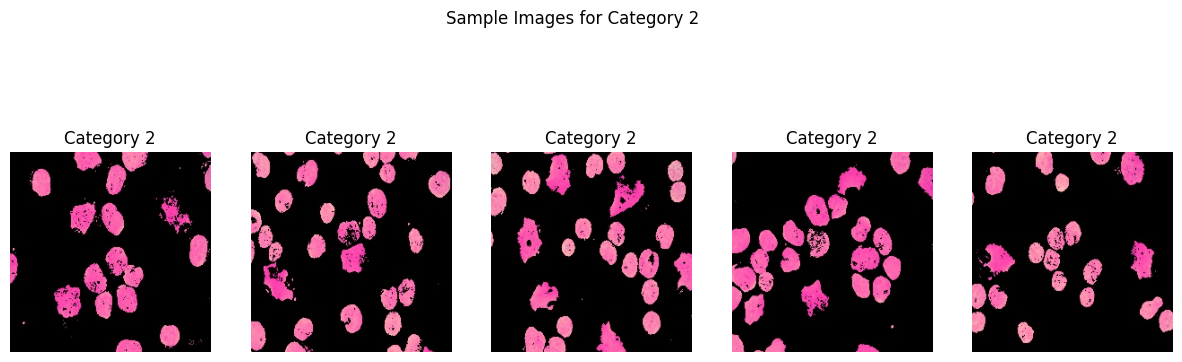

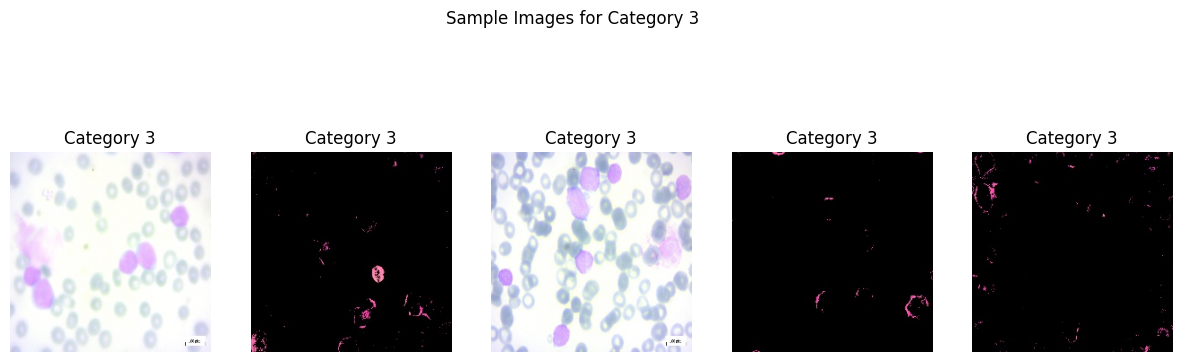

In [ ]:
import random

# Display a few random images per category
num_samples = 5  # Number of images to show per category
for category in np.unique(labels):
    category_indices = np.where(labels == category)[0]
    sample_indices = random.sample(list(category_indices), min(num_samples, len(category_indices)))
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(sample_indices):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[idx])
        plt.title(f"Category {category}")
        plt.axis('off')
    plt.suptitle(f"Sample Images for Category {category}")
    plt.show()

iii) Image Size and Aspect Ratio Check: Verify if all images are uniformly sized after resizing (224x224 in this case)

In [ ]:
# Check dimensions of images
image_shapes = [img.shape for img in images]
unique_shapes = set(image_shapes)
print("Unique image shapes:", unique_shapes)

Unique image shapes: {(224, 224, 3)}


iv) Class Distribution: Analyze class balance to see if any categories are underrepresented.

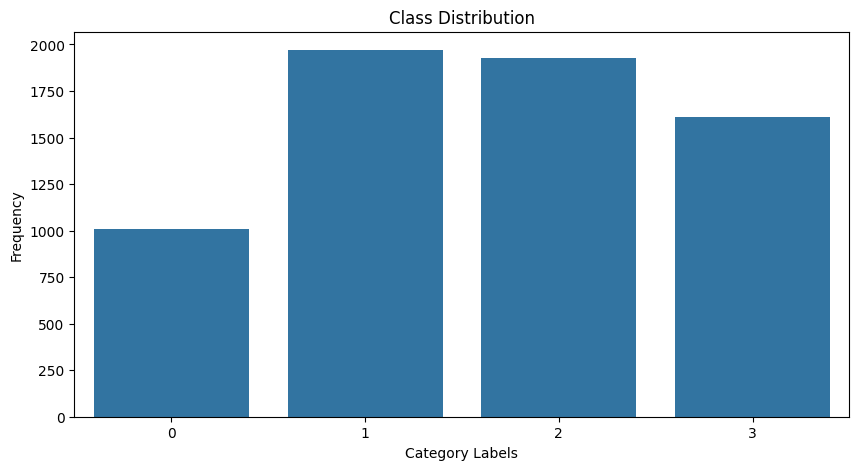

In [ ]:
# Calculate and plot class distribution
plt.figure(figsize=(10, 5))
sns.countplot(x=labels)
plt.xlabel("Category Labels")
plt.ylabel("Frequency")
plt.title("Class Distribution")
plt.show()

v) Color Intensity or Brightness Distribution: Compute and visualize the brightness or color intensities, as they can affect how well models learn features.

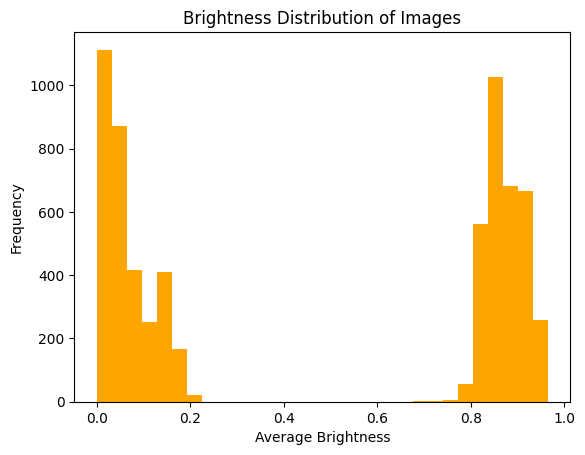

In [ ]:
# Calculate average brightness per image
avg_brightness = [np.mean(img) for img in images]
plt.hist(avg_brightness, bins=30, color='orange')
plt.xlabel("Average Brightness")
plt.ylabel("Frequency")
plt.title("Brightness Distribution of Images")
plt.show()

vi) Outlier Detection: Visualize pixel intensity distributions and manually inspect images with extreme brightness or contrast values for anomalies.

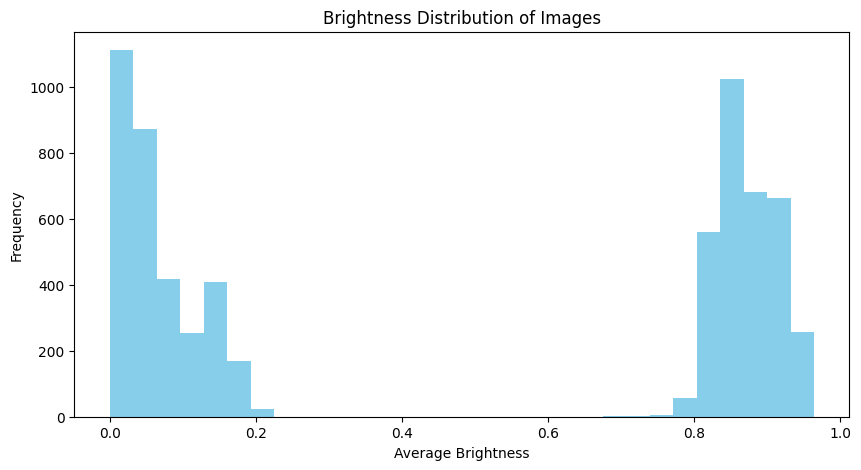

Lower brightness threshold (5th percentile): 0.004034444506969455
Upper brightness threshold (95th percentile): 0.9271306256877753
Displaying low-brightness outlier images:


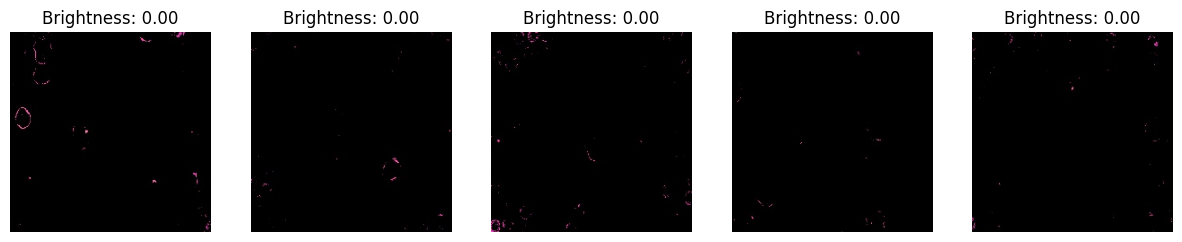

Displaying high-brightness outlier images:


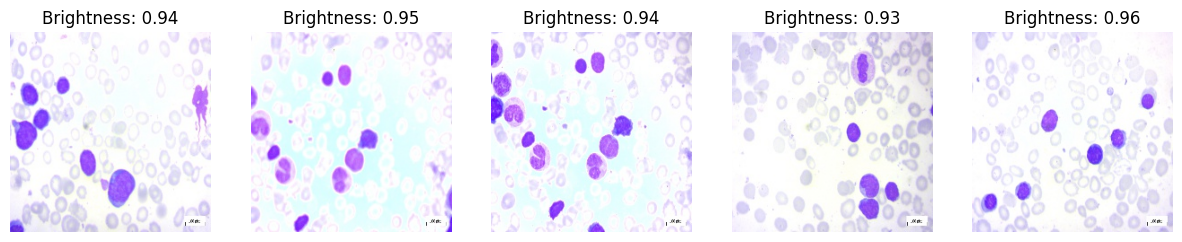

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Calculate average brightness of each image
average_brightness = [np.mean(img) for img in images]

# Step 2: Plot histogram of brightness distribution
plt.figure(figsize=(10, 5))
plt.hist(average_brightness, bins=30, color='skyblue')
plt.xlabel("Average Brightness")
plt.ylabel("Frequency")
plt.title("Brightness Distribution of Images")
plt.show()

# Step 3: Determine brightness thresholds for outliers (e.g., 5th and 95th percentiles)
lower_threshold = np.percentile(average_brightness, 5)
upper_threshold = np.percentile(average_brightness, 95)
print(f"Lower brightness threshold (5th percentile): {lower_threshold}")
print(f"Upper brightness threshold (95th percentile): {upper_threshold}")

# Identify indices of potential outlier images
low_brightness_indices = [i for i, brightness in enumerate(average_brightness) if brightness < lower_threshold]
high_brightness_indices = [i for i, brightness in enumerate(average_brightness) if brightness > upper_threshold]

# Step 4: Display some low-brightness and high-brightness outlier images
# Low-brightness outliers
print("Displaying low-brightness outlier images:")
plt.figure(figsize=(15, 5))
for i, idx in enumerate(low_brightness_indices[:5]):  # Display up to 5 low-brightness images
    plt.subplot(1, 5, i + 1)
    plt.imshow(images[idx])
    plt.title(f"Brightness: {average_brightness[idx]:.2f}")
    plt.axis('off')
plt.show()

# High-brightness outliers
print("Displaying high-brightness outlier images:")
plt.figure(figsize=(15, 5))
for i, idx in enumerate(high_brightness_indices[:5]):  # Display up to 5 high-brightness images
    plt.subplot(1, 5, i + 1)
    plt.imshow(images[idx])
    plt.title(f"Brightness: {average_brightness[idx]:.2f}")
    plt.axis('off')
plt.show()

#4. Model Selection
##Training & Testing & Evaluation of the Model comes under this.

## i) VGG16

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam

# Load the pre-trained VGG16 model without the top classification layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model to prevent them from being updated during training
for layer in base_model.layers:
    layer.trainable = False

# Create a new model by adding a Flatten layer and a Dense layer on top of the base model
model = Sequential()
model.add(base_model)  # Add the VGG16 base model
model.add(layers.GlobalAveragePooling2D())  # Use GlobalAveragePooling2D to reduce dimensionality
model.add(layers.Dense(256, activation='relu'))  # Add a Dense layer with 256 neurons
model.add(layers.Dropout(0.5))  # Dropout for regularization
model.add(layers.Dense(4, activation='softmax'))  # Add a Dense layer with 4 output units for classification

# Compile the model using sparse_categorical_crossentropy for integer labels
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',  # Use sparse categorical crossentropy
              metrics=['accuracy'])

# Fit the model using the data generator
model.fit(train_generator, epochs=4, validation_data=validation_generator)


Epoch 1/4


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


653/653 ━━━━━━━━━━━━━━━━━━━━ 4320s 7s/step - accuracy: 0.8314 - loss: 0.4625 - val_accuracy: 0.9954 - val_loss: 0.0226
Epoch 2/4
653/653 ━━━━━━━━━━━━━━━━━━━━ 4309s 7s/step - accuracy: 0.9995 - loss: 0.0253 - val_accuracy: 0.9985 - val_loss: 0.0074
Epoch 3/4
653/653 ━━━━━━━━━━━━━━━━━━━━ 4267s 7s/step - accuracy: 0.9996 - loss: 0.0086 - val_accuracy: 0.9992 - val_loss: 0.0049
Epoch 4/4
653/653 ━━━━━━━━━━━━━━━━━━━━ 4269s 7s/step - accuracy: 0.9998 - loss: 0.0045 - val_accuracy: 0.9985 - val_loss: 0.0035


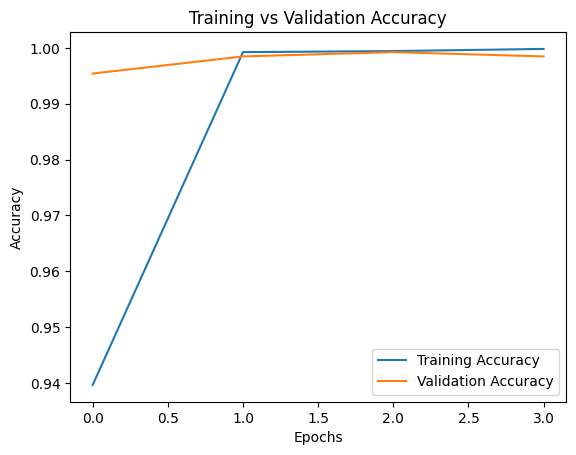

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(model.history.history['accuracy'], label='Training Accuracy')
plt.plot(model.history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


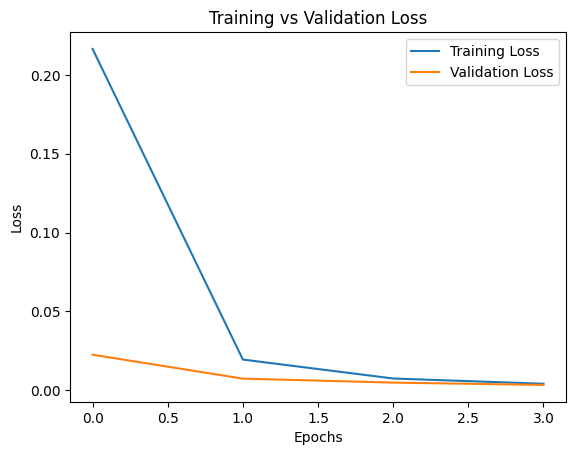

In [ ]:
# Plot training and validation loss
plt.plot(model.history.history['loss'], label='Training Loss')
plt.plot(model.history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


## ii) ResNet50

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# Load ResNet50 model with pre-trained weights, excluding the top layers
base_model2 = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base model layers so they won't be trained
for layer in base_model2.layers:
    layer.trainable = False

# Build the complete model
model2 = Sequential([
    base_model2,                                # Add ResNet50 as the base
    layers.GlobalAveragePooling2D(),           # Global average pooling layer to reduce dimensionality
    layers.Dense(256, activation='relu'),      # Dense layer for feature learning
    layers.Dropout(0.5),                       # Dropout for regularization
    layers.Dense(4, activation='softmax')      # Output layer for 4 classes
])

# Compile the model
model2.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',  # Use sparse categorical crossentropy for integer labels
    metrics=['accuracy']
)

# Add early stopping to monitor validation loss
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model2.fit(
    train_generator,
    epochs=4,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

# Print completion message
print("Training with ResNet50 complete!")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/4
653/653 ━━━━━━━━━━━━━━━━━━━━ 1312s 2s/step - accuracy: 0.6008 - loss: 0.8063 - val_accuracy: 0.9195 - val_loss: 0.4506
Epoch 2/4
653/653 ━━━━━━━━━━━━━━━━━━━━ 1304s 2s/step - accuracy: 0.8045 - loss: 0.4497 - val_accuracy: 0.9095 - val_loss: 0.3433
Epoch 3/4
653/653 ━━━━━━━━━━━━━━━━━━━━ 1297s 2s/step - accuracy: 0.8709 - loss: 0.3498 - val_accuracy: 0.9770 - val_loss: 0.2666
Epoch 4/4
653/653 ━━━━━━━━━━━━━━━━━━━━ 1300s 2s/step - accuracy: 0.9406 - loss: 0.2601 - val_accuracy: 0.9870 - val_loss: 0.2005
Training with ResNet50 complete!


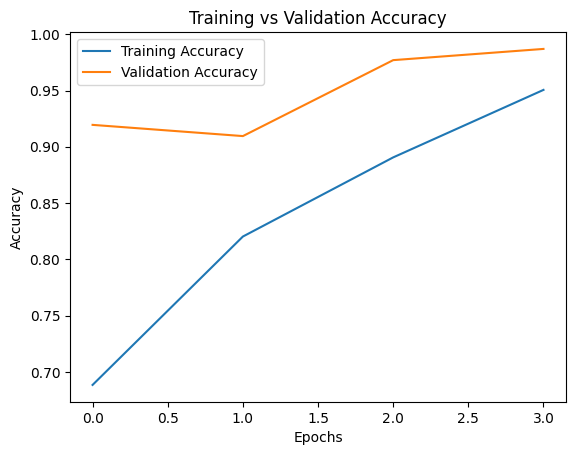

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

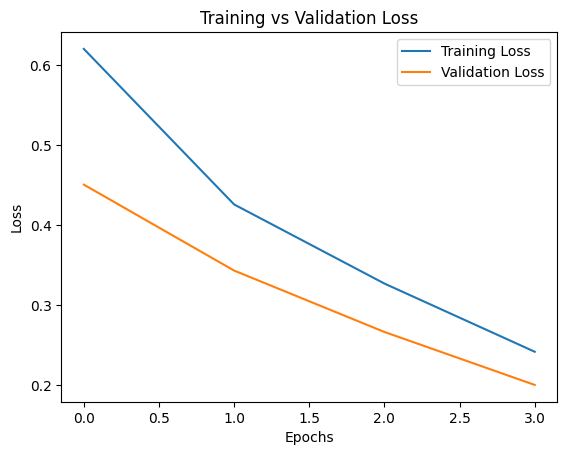

In [ ]:
# Plot training vs validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# iii)Random Forest and SVM

RF and SVM **typically works with tabular data, so here’s a common approach:**

1.Extract Features from Images: Use a CNN (e.g., VGG16 or ResNet50) as a feature extractor to generate a compact feature representation of each image.

2.Train RF on Extracted Features: Feed the extracted features into a Random Forest classifier  and SVM to perform the final classification.

In [ ]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D

# Initialize the base VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
feature_extractor = Model(inputs=base_model.input, outputs=GlobalAveragePooling2D()(base_model.output))

# Function to extract features directly from generator
def extract_features_all(generator, feature_extractor):
    features = feature_extractor.predict(generator, verbose=1)
    labels = np.concatenate([generator[i][1] for i in range(len(generator))])  # Extract labels in one go
    return features, labels

# Run feature extraction with optimized method
train_features, train_labels = extract_features_all(train_generator, feature_extractor)
val_features, val_labels = extract_features_all(validation_generator, feature_extractor)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


653/653 ━━━━━━━━━━━━━━━━━━━━ 3409s 5s/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 843s 5s/step


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train on extracted features
rf_model.fit(train_features, train_labels)

# Evaluate on validation data
val_predictions = rf_model.predict(val_features)
print("Validation Accuracy:", accuracy_score(val_labels, val_predictions))
print(classification_report(val_labels, val_predictions))


Validation Accuracy: 0.504601226993865
              precision    recall  f1-score   support

         0.0       0.50      0.47      0.49       651
         1.0       0.51      0.53      0.52       653

    accuracy                           0.50      1304
   macro avg       0.50      0.50      0.50      1304
weighted avg       0.50      0.50      0.50      1304



In [ ]:

from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D

# Load VGG16 with fine-tuned layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers[-4:]:  # Make last few layers trainable for fine-tuning
    layer.trainable = True

# Define a feature extraction model
feature_extractor = Model(inputs=base_model.input, outputs=GlobalAveragePooling2D()(base_model.output))

# Extract features function
def extract_features(generator, feature_extractor):
    features = feature_extractor.predict(generator, verbose=1)
    labels = np.concatenate([generator[i][1] for i in range(len(generator))])
    return features, labels

# Run feature extraction
train_features, train_labels = extract_features(train_generator, feature_extractor)
val_features, val_labels = extract_features(validation_generator, feature_extractor)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


653/653 ━━━━━━━━━━━━━━━━━━━━ 3061s 5s/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 758s 5s/step


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Initialize Random Forest with more trees and max depth to improve performance
rf_model = RandomForestClassifier(n_estimators=200, max_depth=30, random_state=42)

# Train RF on extracted features
rf_model.fit(train_features, train_labels)

# Predict on validation features
val_predictions = rf_model.predict(val_features)

# Evaluate accuracy and detailed performance metrics
print("Random Forest Validation Accuracy:", accuracy_score(val_labels, val_predictions))
print(classification_report(val_labels, val_predictions))


Random Forest Validation Accuracy: 0.48773006134969327
              precision    recall  f1-score   support

         0.0       0.49      0.50      0.49       651
         1.0       0.49      0.48      0.48       653

    accuracy                           0.49      1304
   macro avg       0.49      0.49      0.49      1304
weighted avg       0.49      0.49      0.49      1304



In [ ]:
# Step 4: Train and Evaluate SVM
svm_model = SVC(kernel='rbf', C=1, gamma='scale', random_state=42)
svm_model.fit(train_features, train_labels)

# Evaluate SVM on validation features
svm_val_predictions = svm_model.predict(val_features)
svm_val_accuracy = accuracy_score(val_labels, svm_val_predictions)
print("SVM Validation Accuracy:", svm_val_accuracy)
print("SVM Classification Report:\n", classification_report(val_labels, svm_val_predictions))


SVM Validation Accuracy: 0.49693251533742333
SVM Classification Report:
               precision    recall  f1-score   support

         0.0       0.50      0.41      0.45       651
         1.0       0.50      0.58      0.54       653

    accuracy                           0.50      1304
   macro avg       0.50      0.50      0.49      1304
weighted avg       0.50      0.50      0.49      1304



hyperparameter tuning

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Grid search for Random Forest
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [20, 30, 40],
    'min_samples_split': [2, 5, 10]
}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=3, scoring='accuracy')
rf_grid.fit(train_features, train_labels)
print("Best RF parameters:", rf_grid.best_params_)
print("Best RF accuracy:", rf_grid.best_score_)

# Grid search for SVM
svm_params = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto']
}
svm_grid = GridSearchCV(SVC(random_state=42), svm_params, cv=3, scoring='accuracy')
svm_grid.fit(train_features, train_labels)
print("Best SVM parameters:", svm_grid.best_params_)
print("Best SVM accuracy:", svm_grid.best_score_)


Best RF parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 300}
Best RF accuracy: 0.5022999521899008
Best SVM parameters: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
Best SVM accuracy: 0.503450148607889


Baseline Random Forest Validation Accuracy: 0.48773006134969327
Baseline SVM Validation Accuracy: 0.49693251533742333
Tuned Random Forest Validation Accuracy: 0.495398773006135
Random Forest Classification Report:
               precision    recall  f1-score   support

         0.0       0.49      0.50      0.50       651
         1.0       0.50      0.49      0.49       653

    accuracy                           0.50      1304
   macro avg       0.50      0.50      0.50      1304
weighted avg       0.50      0.50      0.50      1304

Tuned SVM Validation Accuracy: 0.5069018404907976
SVM Classification Report:
               precision    recall  f1-score   support

         0.0       0.51      0.48      0.49       651
         1.0       0.51      0.53      0.52       653

    accuracy                           0.51      1304
   macro avg       0.51      0.51      0.51      1304
weighted avg       0.51      0.51      0.51      1304



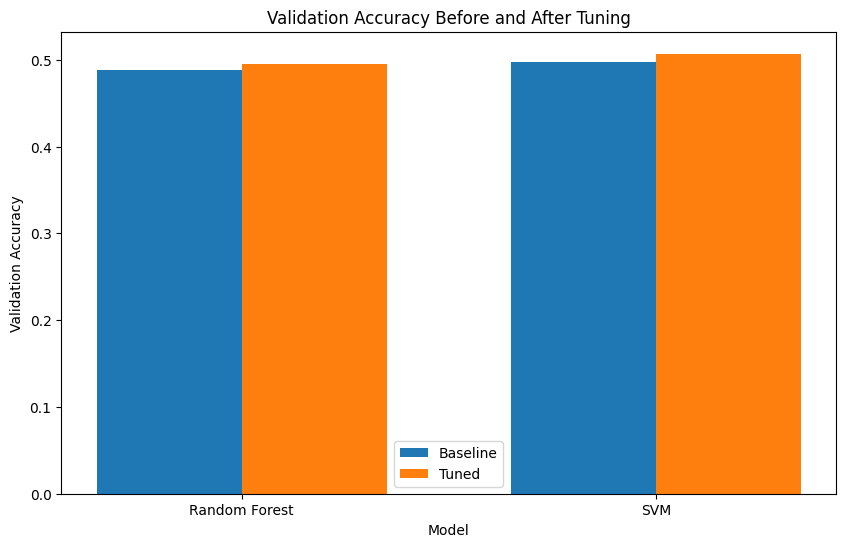

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score

# Original Baseline Model Performance (already computed)
print("Baseline Random Forest Validation Accuracy:", accuracy_score(val_labels, val_predictions))
print("Baseline SVM Validation Accuracy:", svm_val_accuracy)

# Tuned Model Performance
# Random Forest
best_rf_model = rf_grid.best_estimator_
best_rf_val_predictions = best_rf_model.predict(val_features)
best_rf_val_accuracy = accuracy_score(val_labels, best_rf_val_predictions)
print("Tuned Random Forest Validation Accuracy:", best_rf_val_accuracy)
print("Random Forest Classification Report:\n", classification_report(val_labels, best_rf_val_predictions))

# SVM
best_svm_model = svm_grid.best_estimator_
best_svm_val_predictions = best_svm_model.predict(val_features)
best_svm_val_accuracy = accuracy_score(val_labels, best_svm_val_predictions)
print("Tuned SVM Validation Accuracy:", best_svm_val_accuracy)
print("SVM Classification Report:\n", classification_report(val_labels, best_svm_val_predictions))

# Visual Comparison of Accuracy Before and After Tuning
models = ['Random Forest', 'SVM']
baseline_accuracies = [accuracy_score(val_labels, val_predictions), svm_val_accuracy]
tuned_accuracies = [best_rf_val_accuracy, best_svm_val_accuracy]

# Plot
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(models))

plt.bar(index, baseline_accuracies, bar_width, label='Baseline')
plt.bar(index + bar_width, tuned_accuracies, bar_width, label='Tuned')

plt.xlabel('Model')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy Before and After Tuning')
plt.xticks(index + bar_width / 2, models)
plt.legend()
plt.show()


###The current dataset may have challenging or subtle differences among classes that make them difficult to separate, even with tuning.
##Hence, RF and SVM are not suitable for the given dataset.

# iv) VGG19

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG19
from tensorflow.keras.optimizers import Adam

# Load the pre-trained VGG19 model without the top classification layer
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model to prevent them from being updated during training
for layer in base_model.layers:
    layer.trainable = False

# Create a new model by adding a Flatten layer and a Dense layer on top of the base model
model = Sequential()
model.add(base_model)  # Add the VGG19 base model
model.add(layers.GlobalAveragePooling2D())  # Use GlobalAveragePooling2D to reduce dimensionality
model.add(layers.Dense(256, activation='relu'))  # Add a Dense layer with 256 neurons
model.add(layers.Dropout(0.5))  # Dropout for regularization
model.add(layers.Dense(4, activation='softmax'))  # Add a Dense layer with 4 output units for classification

# Compile the model using sparse_categorical_crossentropy for integer labels
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',  # Use sparse categorical crossentropy
              metrics=['accuracy'])

# Fit the model using the data generator
history = model.fit(train_generator, epochs=4, validation_data=validation_generator)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/4


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


652/652 ━━━━━━━━━━━━━━━━━━━━ 5220s 8s/step - accuracy: 0.8097 - loss: 0.5041 - val_accuracy: 0.9954 - val_loss: 0.0324
Epoch 2/4
652/652 ━━━━━━━━━━━━━━━━━━━━ 5173s 8s/step - accuracy: 0.9985 - loss: 0.0271 - val_accuracy: 0.9977 - val_loss: 0.0136
Epoch 3/4
652/652 ━━━━━━━━━━━━━━━━━━━━ 5163s 8s/step - accuracy: 0.9988 - loss: 0.0108 - val_accuracy: 0.9992 - val_loss: 0.0061
Epoch 4/4
652/652 ━━━━━━━━━━━━━━━━━━━━ 5226s 8s/step - accuracy: 0.9989 - loss: 0.0073 - val_accuracy: 1.0000 - val_loss: 0.0042


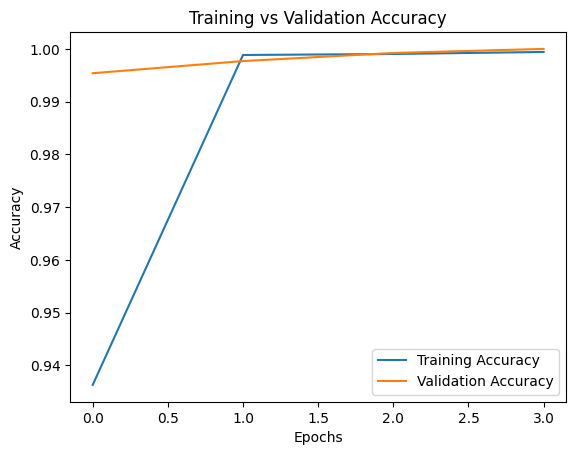

In [ ]:
import matplotlib.pyplot as plt

# Plot training vs. validation accuracy

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()


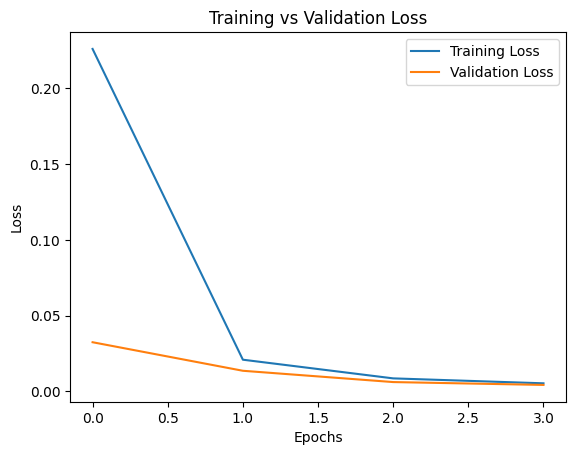

In [ ]:
# Plot training vs validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# v) ResNet-34

In [ ]:
from tensorflow.keras import layers, models, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def residual_block(inputs, filters, stride=1):
    x = layers.Conv2D(filters, kernel_size=(3, 3), strides=stride, padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, kernel_size=(3, 3), strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)

    if stride != 1 or inputs.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, kernel_size=(1, 1), strides=stride, padding='same')(inputs)
        shortcut = layers.BatchNormalization()(shortcut)
    else:
        shortcut = inputs

    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    return x

def build_resnet34(input_shape=(224, 224, 3), num_classes=4):
    inputs = layers.Input(shape=input_shape)

    # Initial Conv layer
    x = layers.Conv2D(64, kernel_size=(7, 7), strides=2, padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

    # Residual blocks for ResNet-34
    x = residual_block(x, 64)
    x = residual_block(x, 64)
    x = residual_block(x, 64)

    x = residual_block(x, 128, stride=2)
    x = residual_block(x, 128)
    x = residual_block(x, 128)
    x = residual_block(x, 128)

    x = residual_block(x, 256, stride=2)
    x = residual_block(x, 256)
    x = residual_block(x, 256)
    x = residual_block(x, 256)
    x = residual_block(x, 256)
    x = residual_block(x, 256)

    x = residual_block(x, 512, stride=2)
    x = residual_block(x, 512)
    x = residual_block(x, 512)

    # Global average pooling and output layer
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

# Build the model
model_resnet34 = build_resnet34(input_shape=(224, 224, 3), num_classes=4)

# Compile the model
model_resnet34.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',  # Use sparse categorical crossentropy for integer labels
    metrics=['accuracy']
)

# Add early stopping to monitor validation loss
early_stopping_resnet34 = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history_resnet34 = model_resnet34.fit(
    train_generator,
    epochs=4,  # You might need to adjust epochs based on model performance
    validation_data=validation_generator,
    callbacks=[early_stopping_resnet34]
)

# Print completion message
print("Training with ResNet-34 complete!")

Epoch 1/4


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


652/652 ━━━━━━━━━━━━━━━━━━━━ 3488s 5s/step - accuracy: 0.9705 - loss: 0.1037 - val_accuracy: 1.0000 - val_loss: 1.8538e-05
Epoch 2/4
652/652 ━━━━━━━━━━━━━━━━━━━━ 3412s 5s/step - accuracy: 0.9997 - loss: 0.0040 - val_accuracy: 0.5000 - val_loss: 5.2050
Epoch 3/4
652/652 ━━━━━━━━━━━━━━━━━━━━ 3410s 5s/step - accuracy: 0.9971 - loss: 0.0155 - val_accuracy: 1.0000 - val_loss: 3.3471e-06
Epoch 4/4
652/652 ━━━━━━━━━━━━━━━━━━━━ 3424s 5s/step - accuracy: 0.9940 - loss: 0.0226 - val_accuracy: 1.0000 - val_loss: 6.2711e-06
Training with ResNet-34 complete!


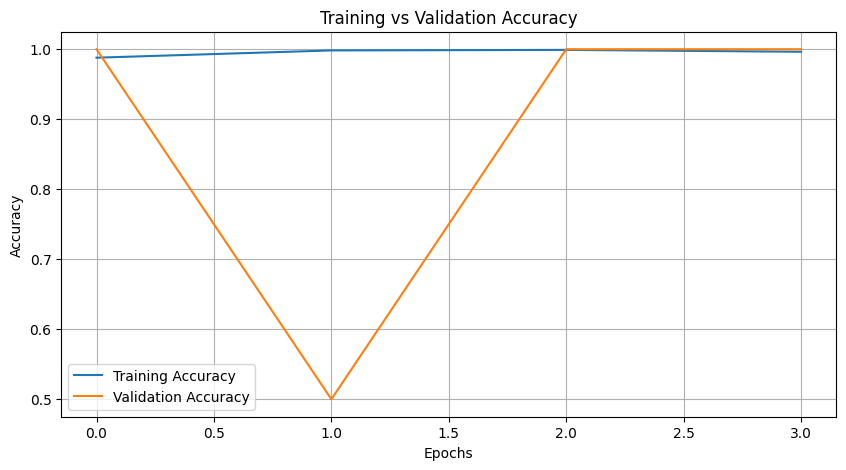

In [ ]:
import matplotlib.pyplot as plt

# Plot training vs validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history_resnet34.history['accuracy'], label='Training Accuracy')
plt.plot(history_resnet34.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

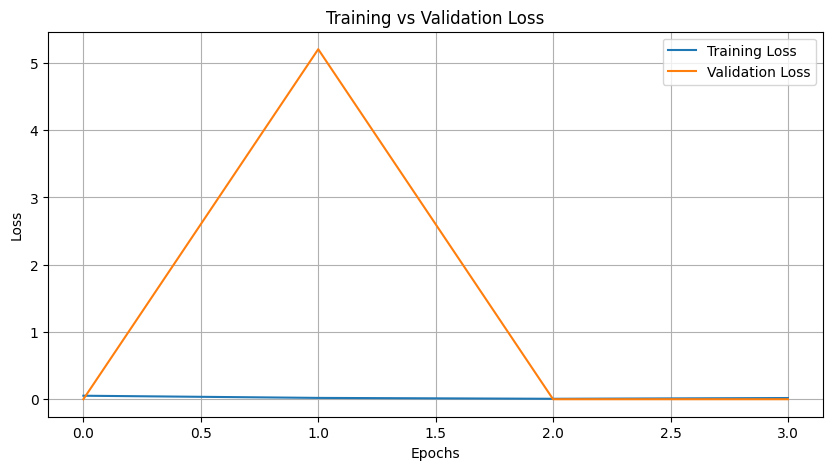

In [ ]:
# Plot training vs validation loss
plt.figure(figsize=(10, 5))
plt.plot(history_resnet34.history['loss'], label='Training Loss')
plt.plot(history_resnet34.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

#**Result**

#1. Model Accuracy Comparison

Purpose: Compare training and validation accuracy across models.

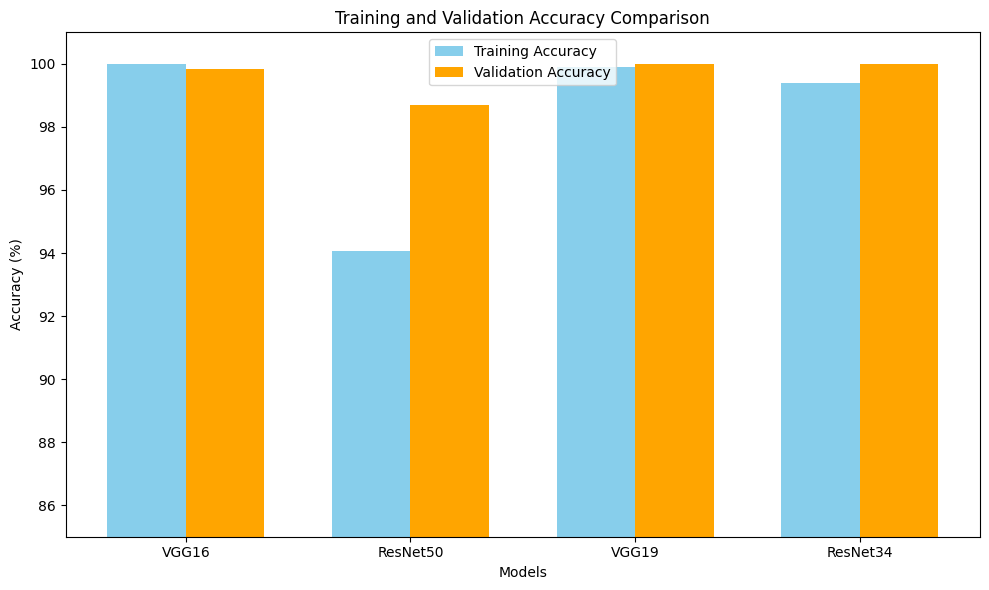

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = ["VGG16", "ResNet50", "VGG19", "ResNet34"]
train_acc = [99.98, 94.06, 99.89, 99.40]
val_acc = [99.85, 98.70, 100.00, 100.00]

# Plot
x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width/2, train_acc, width, label="Training Accuracy", color="skyblue")
ax.bar(x + width/2, val_acc, width, label="Validation Accuracy", color="orange")

# Labels and titles
ax.set_xlabel("Models")
ax.set_ylabel("Accuracy (%)")
ax.set_title("Training and Validation Accuracy Comparison")
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
plt.ylim([85, 101])  # Set y-axis limit for better visualization

# Show
plt.tight_layout()
plt.show()


#2. Loss Curve (Per Model)

Purpose: Show how loss decreases across epochs for each model.

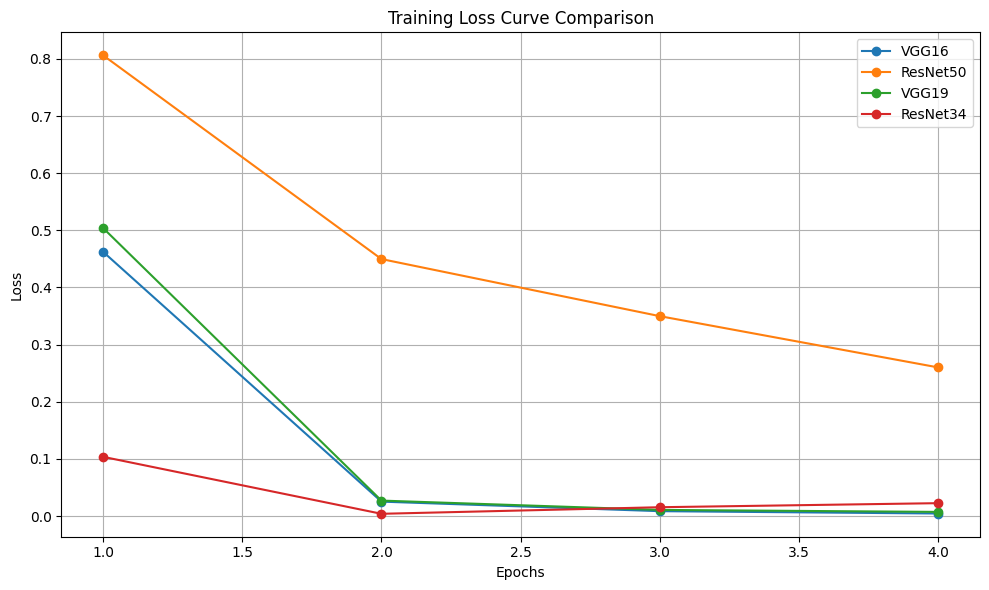

In [10]:
# Data
epochs = [1, 2, 3, 4]
vgg16_loss = [0.4625, 0.0253, 0.0086, 0.0045]
resnet50_loss = [0.8063, 0.4497, 0.3498, 0.2601]
vgg19_loss = [0.5041, 0.0271, 0.0108, 0.0073]
resnet34_loss = [0.1037, 0.0040, 0.0155, 0.0226]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, vgg16_loss, label="VGG16", marker="o")
plt.plot(epochs, resnet50_loss, label="ResNet50", marker="o")
plt.plot(epochs, vgg19_loss, label="VGG19", marker="o")
plt.plot(epochs, resnet34_loss, label="ResNet34", marker="o")

# Labels and titles
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Curve Comparison")
plt.legend()
plt.grid(True)

# Show
plt.tight_layout()
plt.show()


#3. Validation Accuracy Across Epochs

Purpose: Compare how validation accuracy changes over epochs.

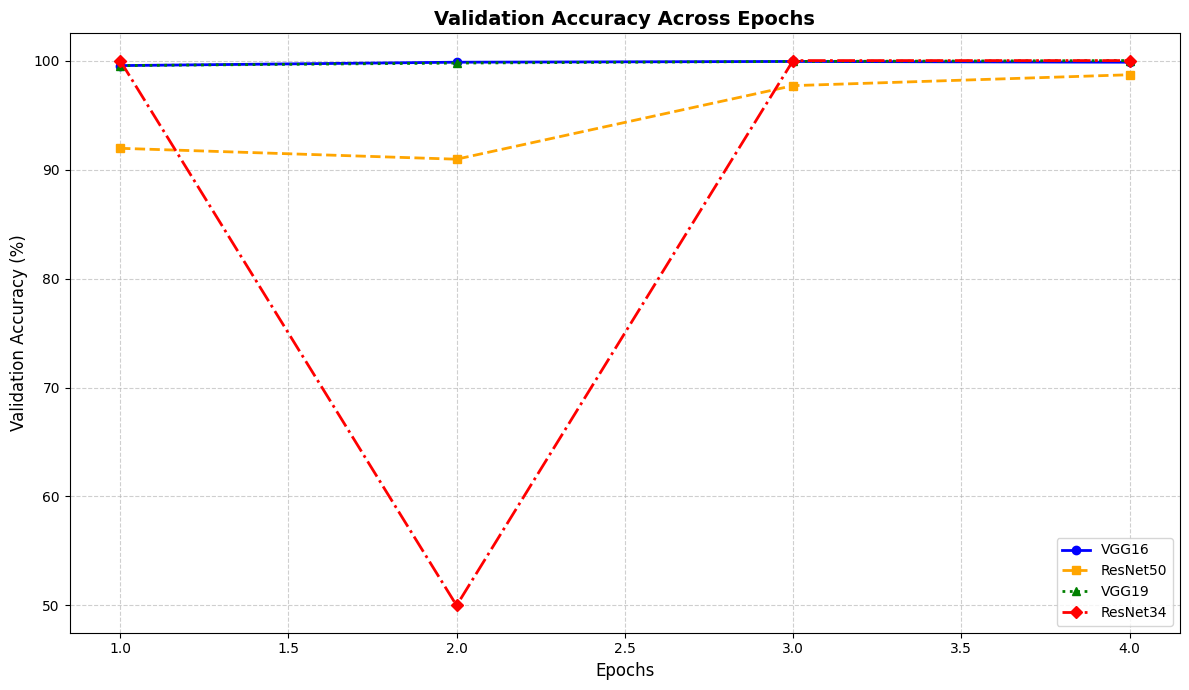

In [12]:
import matplotlib.pyplot as plt

# Data
epochs = [1, 2, 3, 4]  # Assuming 4 epochs
vgg16_val_acc = [99.54, 99.85, 99.92, 99.85]
resnet50_val_acc = [91.95, 90.95, 97.70, 98.70]
vgg19_val_acc = [99.54, 99.77, 99.92, 100.00]
resnet34_val_acc = [100.00, 50.00, 100.00, 100.00]

# Plot
plt.figure(figsize=(12, 7))
plt.plot(epochs, vgg16_val_acc, label="VGG16", marker="o", linestyle="-", linewidth=2, color="blue")
plt.plot(epochs, resnet50_val_acc, label="ResNet50", marker="s", linestyle="--", linewidth=2, color="orange")
plt.plot(epochs, vgg19_val_acc, label="VGG19", marker="^", linestyle=":", linewidth=2, color="green")
plt.plot(epochs, resnet34_val_acc, label="ResNet34", marker="D", linestyle="-.", linewidth=2, color="red")

# Labels and titles
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Validation Accuracy (%)", fontsize=12)
plt.title("Validation Accuracy Across Epochs", fontsize=14, fontweight="bold")
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, linestyle="--", alpha=0.6)

# Adjust layout and show
plt.tight_layout()
plt.show()
